I removed an assertion at: c:\Users\jv97\anaconda3\envs\myenv\lib\site-packages\torchdiffeq\_impl\misc.py

at line 215

In [1]:
import torch as t
from torchdiffeq import odeint_adjoint as odeint

import matplotlib.pyplot as plt

In [354]:
times2 = t.linspace(0,30,1000)

y0 = t.eye(2).cfloat().flatten()

def Ht(time):
    # return t.cos(2*t.pi/10*time)*t.tensor([[0,1],[1,0]]).cfloat()
    return 1/t.sqrt(t.tensor(2))*(t.tensor([[0,1],[1,0]]).cfloat() + t.tensor([[0,-1j],[1j,0]]))

In [355]:
class Lambda(t.nn.Module):
    def forward(self, time, y):
        B0 = 0.9949634671211243
        U = y.view(2,2)
        H = B0*Ht(time)
        return (-1j*H@U).flatten()

In [366]:
with t.no_grad():
    true_U = odeint(Lambda(),y0=y0,t=times2,method='scipy_solver',options={'solver':'DOP853', 'vectorized':True})

c:\Users\jv97\anaconda3\envs\myenv\lib\site-packages\torchdiffeq\_impl\misc.py:11: UserWarning: ScipyWrapperODESolver: Unexpected arguments {'vectorized': True}
  warnings.warn('{}: Unexpected arguments {}'.format(solver.__class__.__name__, unused_kwargs))


In [356]:
help(odeint)

Help on function odeint_adjoint in module torchdiffeq._impl.adjoint:

odeint_adjoint(func, y0, t, *, rtol=1e-07, atol=1e-09, method=None, options=None, event_fn=None, adjoint_rtol=None, adjoint_atol=None, adjoint_method=None, adjoint_options=None, adjoint_params=None)



In [61]:
occs2 = (true_U.view(-1,2,2)@t.tensor([1,0]).cfloat()).abs().square()

In [70]:
true_U.view(-1,2,2)[-1].abs().square().sum(0)

tensor([1.0000, 1.0000])

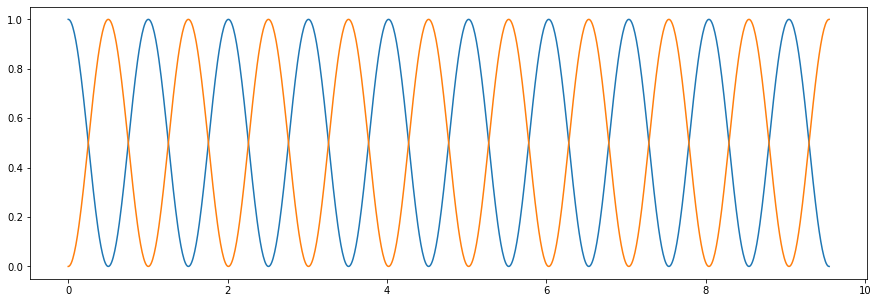

In [63]:
fig, ax = plt.subplots(figsize=(15,5))
# ax.plot(times/t.pi,occs[:,0],'b.')
# ax.plot(times/t.pi,occs[:,1],'r.')
ax.plot(times2/t.pi,occs2)
# ax.set_xlim(2.1220,2.1225)

In [13]:
help(odeint)

Help on function odeint_adjoint in module torchdiffeq._impl.adjoint:

odeint_adjoint(func, y0, t, *, rtol=1e-07, atol=1e-09, method=None, options=None, event_fn=None, adjoint_rtol=None, adjoint_atol=None, adjoint_method=None, adjoint_options=None, adjoint_params=None)



In [290]:
def Ht(time):
    # return t.cos(2*t.pi/10*time)*t.tensor([[0,1],[1,0]]).cfloat()
    return t.tensor([[0,1],[1,0]]).cfloat()
    # return 1/t.sqrt(t.tensor(2))*(t.tensor([[0,1],[1,0]]).cfloat() + t.tensor([[0,-1j],[1j,0]]))

class ODEFunc(t.nn.Module):
    def __init__(self):
        super().__init__()
        self.B0 = t.nn.parameter.Parameter(t.tensor(1.0))
    
    def forward(self, time, y):
        U = y.view(2,2)
        H = self.B0*Ht(time)
        return (-1j*H@U).flatten()
func = ODEFunc()

In [291]:
optimizer = t.optim.Adam(func.parameters(),lr=1e-2)

In [292]:
target_gate_adj = t.tensor([[0,1],[1,0]]).cfloat().adjoint()
def loss_func(U):
    return 1 - 0.25*t.square(t.abs(t.trace(target_gate_adj@U)))

weights = 1/(1+t.exp(times-25))
def loss_func2(Us):
    occs = (Us@t.tensor([1,0]).cfloat()).abs().square()*weights.view(-1,1)
    return 1 - occs[:,1].mean() + occs[:,0].mean()
    # return (1-occs[:,1]).square().mean()
    # return (occs[2:] -2*occs[1:-1] + occs[:-2]).abs().mean()
    # return t.mean((0.5 - occs[:,1])**(-10))

In [293]:
# torchdiffeq = importlib.reload(torchdiffeq)
B0s = []
losss = []
def train(Nepochs):
    for i in range(Nepochs):
        optimizer.zero_grad()
        pred_y = odeint(func,
                        y0=y0,
                        t=t.linspace(0,30,500),
                        rtol=1e-03,
                        atol=1e-06,
                        adjoint_rtol=None,
                        adjoint_atol=None,
                        method='scipy_solver',
                        options={'solver':'RK45'}, #BDF
                        adjoint_method="scipy_solver",
                        adjoint_options={'solver':'RK45'})
        # return pred_y
        U = pred_y.view(-1,2,2)
        loss = 0*loss_func(U[-1]) + loss_func2(U)
        loss.backward()
        optimizer.step()

        with t.no_grad():
            losss.append(loss.item())
            B0s.append(func.B0.item())
            print(f"loss: {loss.item()}, step: {i}", end='\r')

In [294]:
tmp = train(10)

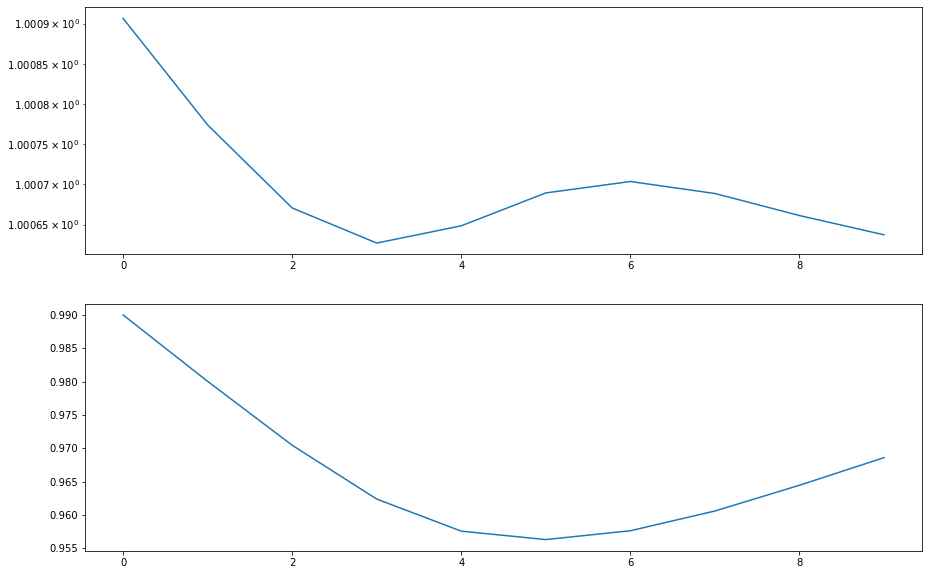

In [295]:
fig, ax = plt.subplots(figsize=(15,10),nrows=2)
ax[0].plot(t.tensor(losss))
ax[0].set_yscale('log')
ax[1].plot(B0s)

In [299]:
times = t.linspace(0,30,500)
class Lambda(t.nn.Module):
    def forward(self, time, y):
        B0 = func.B0.item()
        U = y.view(2,2)
        H = B0*Ht(time)
        return (-1j*H@U).flatten()

with t.no_grad():
    true_U = odeint(Lambda(),y0=y0,t=times,method='scipy_solver',options={'solver':'RK45'})

occs = (true_U.view(-1,2,2)@t.tensor([1,0]).cfloat()).abs().square()

In [288]:
occs.shape

torch.Size([500, 2])

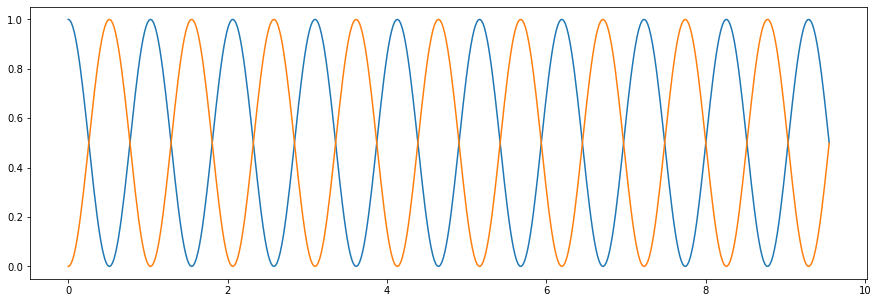

In [300]:
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(times/t.pi,occs)

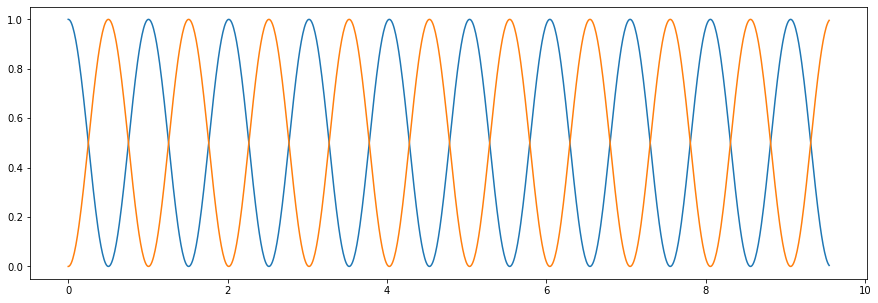

In [198]:
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(times/t.pi,occs)

# How slow are they for the matrices we need

In [2]:
import torch as t
import matplotlib.pyplot as plt
import os

import sys
dir_path = os.path.dirname(os.getcwd())
sys.path.append(os.path.join(dir_path,'scripts'))

import importlib
import Systems as Systems
import Plotting as Plotting
import Controls as Controls
import Evolvers as Evolvers

from tqdm import tqdm
from time import time

In [3]:
importlib.reload(Systems)
importlib.reload(Plotting)
importlib.reload(Controls)
importlib.reload(Evolvers)

<module 'Evolvers' from 'c:\\Users\\jv97\\github\\Quantum-Optimal-Control\\scripts\\Evolvers.py'>

In [340]:
params_dict = {
"T": 		30,
"NTrot": 	1000,
"q_max": 	10,
"lr": 		3e-4,
"Scheduler":	True,
"loss_funcs":	["C1_gate"],
"subNHilbert":  30,
"dim":          "2d",

"_SystemComments":"The following are the specifications for the 1DFlensmon, with respectively: 0.997*pi, 2*pi*10GHz and EJ/100",

"phi_ext": 3.132167875629024,
"EJ": 		62.83185307179586,
"EC": 		0.6283185307179586,

"decline_end":	10.0,
"ascend_start":	20.0,
"level":	1.0,
"envelope_amp":	0.2397,
"detuning":	0.2956,
"phase":	1.7529
}

In [341]:
class model(t.nn.Module,Systems.Periodic_System, Evolvers.QTrotter):
    def __init__(self,params_dict):
        super().__init__()
        self.beta = 1.0
        self.params_dict = params_dict

        self.ReLU = t.nn.ReLU()
        self.heights = t.nn.parameter.Parameter(self.init_heights())
        self.prior_sigma = t.log(t.ones(998)/500)
        self.log_sigma = t.nn.parameter.Parameter(self.prior_sigma.clone())

        super(t.nn.Module,self).__init__()
        # self.prepare_target_gate_adj()
    
    def init_heights(self):
        time = t.linspace(0,30,1000)[1:-1]
        alphas = t.sin(time)*t.exp(-(time-15)**2/10) + t.exp(-time/3) + t.exp(-(30 - time)/3)
        alphas = alphas - alphas.min()
        alphas = alphas/alphas.max()/2
        alphas = alphas + 0.5
        return self.restrict_output(self.restrict_diff(alphas)[1:-1],0.5,1)
        # return time*(time-30)/500 + 1

    def restrict_output(self,inp,Min,Max):
        return self.ReLU(inp - Min) - self.ReLU(inp - Max) + Min
    
    def forward(self, times, y):
        ind = (self.times - times).abs().argmin().item()
        alphas = self.restrict_output(self.heights,0.5,1.0)
        alphas = self.restrict_diff(alphas)[[ind]]
        H = self.get_H(alphas=alphas).squeeze()
        U = y#.view(30,30)
        # self.latest_matrix_exp = t.matrix_exp(-1j*H*self.dt)
        # U = t.linalg.multi_dot(list(mat for mat in self.latest_matrix_exp.flip(0)))
        return (-1j*H@U).flatten()
    
    def V_2d(self, alphas, control):
        return self.EJ*(-self.cos_mat.repeat((alphas.shape[0],1,1)) \
                            - alphas.view(-1,1,1)*self.cos2_mat \
                            + control.view(-1,1,1)*self.q_mat)
    
    def get_jac(self, times, y):
        ind = (self.times - times).abs().argmin().item()
        alphas = self.restrict_output(self.heights,0.5,1.0)
        alphas = self.restrict_diff(alphas)[[ind]]
        H = self.get_H(alphas=alphas).squeeze()
        out = -1j*H
        # return t.block_diag(*(out for _ in range(30)))
        return out
    
    def prepare_target_gate_adj(self):
        tmp = t.eye(self.subNHilbert,dtype=t.cfloat)
        tmp[0,0] = 0
        tmp[0,1] = 1
        tmp[1,0] = 1
        tmp[1,1] = 0
        self.target_gate_adj = tmp.adjoint()
        self.basis_change = self.basis.adjoint()@self.eigvecs[:,:self.subNHilbert]
    
    def C1_gate(self,U):
        transformed = self.basis_change.adjoint()@U@self.basis_change
        dim = 2
        return 1 - 1/dim**2*t.square(t.abs(t.trace(self.target_gate_adj[:dim]@transformed[:,:dim])))
    
    def restrict_diff(self,heights):
        max_diff = 0.01
        out = t.zeros(heights.shape[0])
        out[0] = heights[0]
        for i in range(heights.shape[0]-1):
            diff = heights[i+1] - out[i]
            out[i+1] = out[i] + self.restrict_output(diff,0,max_diff) + self.restrict_output(diff,-max_diff,0)
        one = t.tensor([1.])
        return t.concat([one,self.restrict_output(out,0.5,1),one])

obj = model(params_dict)

I added a factor half to the cosines


In [349]:
optimizer = t.optim.Adam(obj.parameters(),lr=1e-3)

In [352]:
B0s = []
losss = []
def train(Nepochs):
    for i in range(Nepochs):
        optimizer.zero_grad()
        pred_y = odeint(obj,
                        y0=t.eye(30).cfloat().flatten(),
                        t=t.tensor([0.,30.]),
                        rtol=1e-03,
                        atol=1e-06,
                        adjoint_rtol=None,
                        adjoint_atol=None,
                        method='scipy_solver',
                        options={'solver':'RK45'}, #BDF
                        adjoint_method="scipy_solver",
                        adjoint_options={'solver':'RK45'})
        print(pred_y)
        U = pred_y.view(30,30)
        loss = obj.C1_gate(U)
        loss.backward()
        optimizer.step()

        with t.no_grad():
            losss.append(loss.item())
            B0s.append(func.B0.item())
            print(f"loss: {loss.item()}, step: {i}", end='\r')

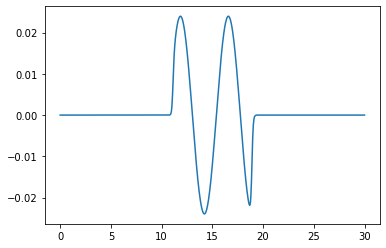

In [205]:
envelope_amp =	0.02397
detuning =	0.2956
phase =	1.7529

decline_end=	10.0+0.1
ascend_start=	20.0-0.1

def get_control(times):
    # times = t.as_tensor(times)
    # eigvals = t.linalg.eigvalsh(self.get_H(level.view(1)).squeeze())
    # omega_d = (eigvals[1] - eigvals[0])
    omega_d = 4.5
    pulse = t.cos(detuning*omega_d*(times - decline_end - phase))
    envelope = envelope_func(times)
    return envelope*pulse

def envelope_func(times):
    return envelope_amp*custom_Sigmoid(times-decline_end)*custom_Sigmoid(ascend_start - times)

def custom_Sigmoid(x):
    return t.sigmoid(20*t.pi/4*(x-1))

plt.plot(obj.times,get_control(obj.times))

In [352]:
def func(times,y):
    times = t.as_tensor(times).view(-1)
    H = obj.get_H(t.tensor([0.7]),get_control(times)).squeeze()
    return -1j*H@y

def jac(times,y):
    times = t.as_tensor(times).view(-1)
    H = obj.get_H(t.tensor([0.7]),get_control(times)).squeeze()
    return -1j*H

In [353]:
# y0 = t.zeros(441).cdouble()
# y0[0] = 1
H = obj.get_H(t.tensor([0.7])).squeeze()
eigvals, eigvecs = t.linalg.eigh(H)
y0 = eigvecs[:,0]
eigvals = eigvals.cdouble()

In [362]:
f = t.diag_embed(eigvals).cdouble()
q_mat = (obj.EJ*eigvecs.adjoint()@obj.q_mat@eigvecs).cdouble()

def func(times,y):
    times = t.as_tensor(times).view(-1)
    H = t.diag_embed(t.exp(1j*eigvals*times))@q_mat@t.diag_embed(t.exp(-1j*eigvals*times))*get_control(times)
    # H = q_mat*get_control(times) + f
    return -1j*H@y

def jac(times,y):
    times = t.as_tensor(times).view(-1)
    H = t.diag_embed(t.exp(1j*eigvals*times))@q_mat@t.diag_embed(t.exp(-1j*eigvals*times))*get_control(times)
    # H = q_mat*get_control(times) + f
    return -1j*H

In [364]:
from scipy.integrate import solve_ivp
with t.no_grad():
    out3 = solve_ivp(func,y0=y0,rtol=1e-10,atol=1e-12,t_span=[10,20],t_eval=t.linspace(10,20,100), vectorized=True,method='BDF',jac=jac)

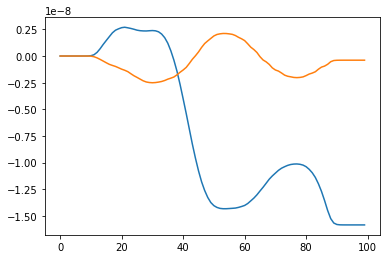

In [371]:
# plt.plot(1- (eigvecs.adjoint().cdouble()@t.as_tensor(out2.y)).abs().square().cumsum(0)[20])
# plt.plot(1- (eigvecs.adjoint().cdouble()@t.as_tensor(out.y)).abs().square().cumsum(0)[20])
plt.plot((1-t.as_tensor(out1.y).abs().square().cumsum(0))[-1])
plt.plot((1-t.as_tensor(out3.y).abs().square().cumsum(0))[-1])

In [363]:
y0 = t.zeros(441).cdouble()
y0[0] = 1

In [332]:
from scipy.integrate import solve_ivp
with t.no_grad():
    out1 = solve_ivp(func,y0=y0,rtol=1e-10,atol=1e-12,t_span=[10,20],t_eval=t.linspace(10,20,100), vectorized=False,method='BDF',jac=jac)

In [338]:
(1-t.as_tensor(out1.y).abs().square().cumsum(0))[-1]

tensor([ 0.0000e+00,  0.0000e+00, -2.2204e-16, -4.4409e-16, -2.6645e-15,
        -9.7700e-15, -2.6867e-14, -2.4647e-14,  4.2533e-13,  4.5145e-12,
         2.8563e-11,  1.2061e-10,  3.4197e-10,  6.8554e-10,  1.0888e-09,
         1.4592e-09,  1.8225e-09,  2.1791e-09,  2.4227e-09,  2.5541e-09,
         2.6608e-09,  2.7001e-09,  2.6482e-09,  2.5865e-09,  2.5115e-09,
         2.4256e-09,  2.3772e-09,  2.3555e-09,  2.3503e-09,  2.3719e-09,
         2.3885e-09,  2.3654e-09,  2.2722e-09,  2.0626e-09,  1.7213e-09,
         1.2088e-09,  4.8880e-10, -3.9216e-10, -1.4328e-09, -2.6663e-09,
        -4.0147e-09, -5.3958e-09, -6.8374e-09, -8.2686e-09, -9.5808e-09,
        -1.0773e-08, -1.1799e-08, -1.2615e-08, -1.3265e-08, -1.3745e-08,
        -1.4037e-08, -1.4204e-08, -1.4296e-08, -1.4326e-08, -1.4326e-08,
        -1.4308e-08, -1.4288e-08, -1.4264e-08, -1.4202e-08, -1.4117e-08,
        -1.4019e-08, -1.3840e-08, -1.3588e-08, -1.3331e-08, -1.3022e-08,
        -1.2661e-08, -1.2312e-08, -1.1936e-08, -1.1

In [249]:
from scipy.integrate import solve_ivp
with t.no_grad():
    out1 = solve_ivp(func,y0=y0,rtol=1e-10,atol=1e-12,t_span=[10,20],t_eval=t.linspace(10,20,100), vectorized=False,method='BDF',jac=jac)

In [273]:
t.diag_embed(t.exp(-1j*eigvals.view(-1,1)*t.linspace(10,20,100))).shape
# t.as_tensor(out1.y).shape

torch.Size([441, 100, 100])

In [315]:
tmp_out = t.diag_embed(t.exp(-1j*eigvals*t.linspace(10,20,100).view(-1,1)))
# eigvals*t.linspace(10,20,100).view(-1,1)
tmp_out = [tmp_out[i]@t.as_tensor(out1.y[:,[i]]) for i in range(100)]
tmp_out = t.concat(tmp_out,dim=1)

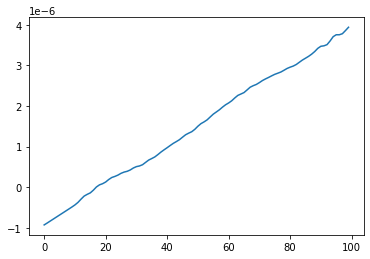

In [351]:
# plt.plot((1-(eigvecs.adjoint().cdouble()@t.as_tensor(out1.y)).abs().square().cumsum(0))[20])
# (1-t.as_tensor(out1.y).abs().square().cumsum(0))
# plt.plot(t.as_tensor(out1.y).abs().square()[:3].T)
plt.plot(1- (eigvecs.adjoint().cdouble()@t.as_tensor(out.y)).abs().square().cumsum(0)[30])
# 1-(eigvecs.adjoint().cdouble()@t.as_tensor(out.y)).abs().square().cumsum(0)

In [208]:
from scipy.integrate import solve_ivp
with t.no_grad():
    out = solve_ivp(func,y0=y0,rtol=1e-10,atol=1e-12,t_span=[10,20],t_eval=t.linspace(10,20,100), vectorized=False,method='BDF',jac=jac)

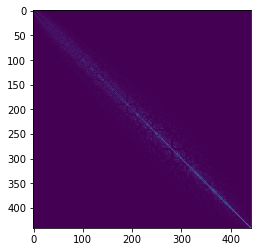

In [235]:
plt.imshow((eigvecs.adjoint()@obj.q_mat@eigvecs).abs())

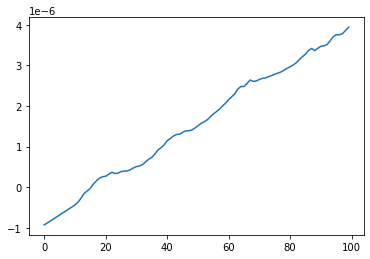

In [226]:
plt.plot((1-(eigvecs.adjoint().cdouble()@t.as_tensor(out.y)).abs().square().cumsum(0))[20])

In [170]:
from scipy.integrate import solve_ivp
with t.no_grad():
    out1 = solve_ivp(func,y0=y0,t_span=[10,20],t_eval=t.linspace(10,20,100), vectorized=False,method='BDF',jac=jac)

In [171]:
out1

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 6072
     njev: 1
      nlu: 549
      sol: None
   status: 0
  success: True
        t: array([10.      , 10.10101 , 10.202021, 10.30303 , 10.40404 , 10.505051,
       10.606061, 10.70707 , 10.808081, 10.909091, 11.010101, 11.111111,
       11.212121, 11.313131, 11.414142, 11.515151, 11.616161, 11.717172,
       11.818182, 11.919191, 12.020202, 12.121212, 12.222222, 12.323232,
       12.424242, 12.525252, 12.626263, 12.727272, 12.828282, 12.929293,
       13.030303, 13.131312, 13.232323, 13.333333, 13.434343, 13.535353,
       13.636363, 13.737373, 13.838384, 13.939393, 14.040403, 14.141414,
       14.242424, 14.343433, 14.444444, 14.545454, 14.646464, 14.747474,
       14.848485, 14.949495, 15.050506, 15.151515, 15.252525, 15.353536,
       15.454546, 15.555555, 15.656566, 15.757576, 15.858586, 15.959596,
       16.060606, 16.161615, 16.262627, 16.363636, 16.464647, 16.565657,
       16.66666

In [155]:
from scipy.integrate import solve_ivp
with t.no_grad():
    out2 = solve_ivp(func,y0=y0,t_span=[10,20],t_eval=t.linspace(10,20,100), vectorized=False,method='BDF',jac=jac)

In [156]:
out2

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 20107
     njev: 2
      nlu: 1802
      sol: None
   status: 0
  success: True
        t: array([10.      , 10.10101 , 10.202021, 10.30303 , 10.40404 , 10.505051,
       10.606061, 10.70707 , 10.808081, 10.909091, 11.010101, 11.111111,
       11.212121, 11.313131, 11.414142, 11.515151, 11.616161, 11.717172,
       11.818182, 11.919191, 12.020202, 12.121212, 12.222222, 12.323232,
       12.424242, 12.525252, 12.626263, 12.727272, 12.828282, 12.929293,
       13.030303, 13.131312, 13.232323, 13.333333, 13.434343, 13.535353,
       13.636363, 13.737373, 13.838384, 13.939393, 14.040403, 14.141414,
       14.242424, 14.343433, 14.444444, 14.545454, 14.646464, 14.747474,
       14.848485, 14.949495, 15.050506, 15.151515, 15.252525, 15.353536,
       15.454546, 15.555555, 15.656566, 15.757576, 15.858586, 15.959596,
       16.060606, 16.161615, 16.262627, 16.363636, 16.464647, 16.565657,
       16.666

In [172]:
1-t.as_tensor(out1.y).abs().square().sum(0)

tensor([ 0.0000e+00, -8.3164e-02, -5.1685e-02, -8.3810e-03,  3.1703e-02,
         6.9600e-02,  6.4513e-02,  1.9287e-02,  1.4566e-02,  1.1034e-02,
         8.1183e-03,  5.5966e-03,  3.3384e-03,  1.3238e-03, -1.4114e-04,
        -6.0171e-04, -3.2996e-04,  8.5886e-05,  5.9205e-04,  9.9895e-04,
         1.3034e-03,  1.6131e-03,  1.8908e-03,  2.1560e-03,  2.4522e-03,
         2.8346e-03,  3.2108e-03,  3.5926e-03,  5.0025e-03,  6.7111e-03,
         8.4380e-03,  1.0181e-02,  1.1937e-02,  1.3438e-02,  1.3126e-02,
         1.3133e-02,  1.3415e-02,  1.3696e-02,  1.3976e-02,  1.4258e-02,
         1.4545e-02,  1.4834e-02,  1.5127e-02,  1.5405e-02,  1.5687e-02,
         1.5962e-02,  1.6233e-02,  1.6517e-02,  1.7586e-02,  1.9112e-02,
         2.0745e-02,  2.2493e-02,  2.3681e-02,  2.3369e-02,  2.3088e-02,
         2.3528e-02,  2.4011e-02,  2.4313e-02,  2.4602e-02,  2.4834e-02,
         2.5136e-02,  2.5533e-02,  2.5986e-02,  2.6412e-02,  2.6725e-02,
         2.7025e-02,  2.7313e-02,  2.7583e-02,  2.9

In [159]:
(1-t.as_tensor(out2.y).abs().square().sum(0))

tensor([-4.6556e-04,  5.2380e+00,  4.8399e+00,  4.8294e+00,  4.8221e+00,
         4.8217e+00,  4.8224e+00,  4.8234e+00,  4.8242e+00,  4.8245e+00,
         4.8287e+00,  4.8367e+00,  4.8390e+00,  4.8399e+00,  4.8405e+00,
         4.8411e+00,  4.8418e+00,  4.8421e+00,  4.8486e+00,  4.8565e+00,
         4.8564e+00,  4.8574e+00,  4.8578e+00,  4.8585e+00,  4.8589e+00,
         4.8619e+00,  4.8701e+00,  4.8739e+00,  4.8742e+00,  4.8749e+00,
         4.8758e+00,  4.8760e+00,  4.8794e+00,  4.8876e+00,  4.8907e+00,
         4.8917e+00,  4.8927e+00,  4.8931e+00,  4.8939e+00,  4.8947e+00,
         4.8991e+00,  4.9073e+00,  4.9103e+00,  4.9110e+00,  4.9119e+00,
         4.9129e+00,  4.9132e+00,  4.9189e+00,  4.9268e+00,  4.9283e+00,
         4.9291e+00,  4.9296e+00,  4.9306e+00,  4.9310e+00,  4.9372e+00,
         4.9451e+00,  4.9450e+00,  4.9455e+00,  4.9462e+00,  4.9469e+00,
         4.9472e+00,  4.9478e+00,  4.9514e+00,  4.9594e+00,  4.9632e+00,
         4.9633e+00,  4.9642e+00,  4.9644e+00,  4.9

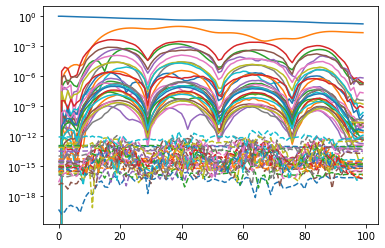

In [149]:
fig, ax = plt.subplots()
occs1 = t.as_tensor(out1.y).abs().square()
occs2 = t.as_tensor(out2.y).abs().square()[:30]

ax.plot(occs1.T)
plt.gca().set_prop_cycle(None)
ax.plot(occs2.T,linestyle='--')
ax.set_yscale('log')

In [121]:
from scipy.integrate import solve_ivp
with t.no_grad():
    out2 = solve_ivp(func,y0=y0,t_span=[10,20],t_eval=t.linspace(10,20,30), vectorized=True,method='BDF',jac=jac)

In [128]:
from scipy.integrate import solve_ivp
with t.no_grad():
    out2 = solve_ivp(func,y0=y0,t_span=[10,20],t_eval=t.linspace(10,20,30), vectorized=True,method='BDF',jac=jac)

KeyboardInterrupt: 

In [119]:
out2

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 748
     njev: 2
      nlu: 52
      sol: None
   status: 0
  success: True
        t: array([10.       , 10.344828 , 10.689655 , 11.034483 , 11.379311 ,
       11.724138 , 12.068966 , 12.413794 , 12.758621 , 13.103449 ,
       13.4482765, 13.793104 , 14.137932 , 14.482759 , 14.827587 ,
       15.172415 , 15.5172415, 15.862069 , 16.206896 , 16.551723 ,
       16.896551 , 17.241379 , 17.586206 , 17.931034 , 18.275862 ,
       18.62069  , 18.965517 , 19.310345 , 19.655172 , 20.       ],
      dtype=float32)
 t_events: None
        y: array([[ 2.14893339e-10+0.00000000e+00j, -5.60896991e-10-2.17286971e-10j,
        -7.22080252e-10-2.50871921e-10j, ...,
        -3.17308025e-07-5.55566203e-07j,  2.03774918e-07-2.58723553e-07j,
         2.47592778e-07-2.31311607e-07j],
       [-1.64734022e-08-1.95577741e-08j, -1.56365063e-08-1.99169946e-08j,
        -1.55024103e-08-2.00026802e-08j, ...,
        -9.57

In [85]:
from scipy.integrate import solve_ivp
with t.no_grad():
    out2 = solve_ivp(func,y0=y0,t_span=[10,20],t_eval=t.linspace(10,20,30), vectorized=True,method='BDF',jac=jac)

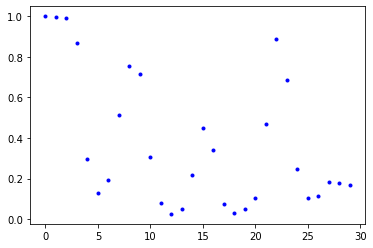

In [97]:
occs = y0.view(-1,1).adjoint().cdouble()@t.as_tensor(out2.y).cdouble()
plt.plot(occs.T.abs().square(),'b.')

In [78]:
from scipy.integrate import solve_ivp
with t.no_grad():
    out2 = solve_ivp(func,y0=y0,t_span=[10,20],t_eval=t.linspace(10,20,30),method='BDF',jac=jac)

In [79]:
out2

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 22574
     njev: 2
      nlu: 2020
      sol: None
   status: 0
  success: True
        t: array([10.       , 10.344828 , 10.689655 , 11.034483 , 11.379311 ,
       11.724138 , 12.068966 , 12.413794 , 12.758621 , 13.103449 ,
       13.4482765, 13.793104 , 14.137932 , 14.482759 , 14.827587 ,
       15.172415 , 15.5172415, 15.862069 , 16.206896 , 16.551723 ,
       16.896551 , 17.241379 , 17.586206 , 17.931034 , 18.275862 ,
       18.62069  , 18.965517 , 19.310345 , 19.655172 , 20.       ],
      dtype=float32)
 t_events: None
        y: array([[ 2.14893339e-10+0.00000000e+00j,  2.06067289e-05-2.57459774e-04j,
        -9.56417011e-05+3.61657809e-04j, ...,
        -7.40326306e-04+2.99652762e-04j,  3.54737346e-04+5.94920617e-04j,
        -5.91746981e-04-3.40337769e-04j],
       [-1.64734022e-08-1.95577741e-08j, -2.59883040e-04+2.54988903e-04j,
        -1.36618380e-05-3.30023575e-04j, ...,
         

In [75]:
from scipy.integrate import solve_ivp
with t.no_grad():
    out = solve_ivp(func,y0=y0,t_span=[10,20],t_eval=t.linspace(10,20,30),solver='BDF')

c:\Users\jv97\anaconda3\envs\myenv\lib\site-packages\scipy\integrate\_ivp\common.py:39: UserWarning: The following arguments have no effect for a chosen solver: `solver`.
  warn("The following arguments have no effect for a chosen solver: {}."


In [76]:
out

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 27080
     njev: 0
      nlu: 0
      sol: None
   status: 0
  success: True
        t: array([10.       , 10.344828 , 10.689655 , 11.034483 , 11.379311 ,
       11.724138 , 12.068966 , 12.413794 , 12.758621 , 13.103449 ,
       13.4482765, 13.793104 , 14.137932 , 14.482759 , 14.827587 ,
       15.172415 , 15.5172415, 15.862069 , 16.206896 , 16.551723 ,
       16.896551 , 17.241379 , 17.586206 , 17.931034 , 18.275862 ,
       18.62069  , 18.965517 , 19.310345 , 19.655172 , 20.       ],
      dtype=float32)
 t_events: None
        y: array([[ 2.14893339e-10+0.00000000e+00j,  6.90223259e-05-3.66648081e-04j,
        -5.05168951e-04+5.16434065e-04j, ...,
         1.46940476e-02-2.84892870e-03j,  1.42760730e-02-6.68183354e-03j,
        -1.60765352e-02-4.00698094e-03j],
       [-1.64734022e-08-1.95577741e-08j, -4.50063396e-05+2.77346737e-04j,
         3.65307462e-04-3.77668819e-04j, ...,
        -1.1

In [65]:
from scipy.integrate import solve_ivp
with t.no_grad():
    out = solve_ivp(func,y0=y0,t_span=[10,20],t_eval=t.linspace(10,20,30),solver='BDF')

In [67]:
out

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 26282
     njev: 0
      nlu: 0
      sol: None
   status: 0
  success: True
        t: array([10.       , 10.344828 , 10.689655 , 11.034483 , 11.379311 ,
       11.724138 , 12.068966 , 12.413794 , 12.758621 , 13.103449 ,
       13.4482765, 13.793104 , 14.137932 , 14.482759 , 14.827587 ,
       15.172415 , 15.5172415, 15.862069 , 16.206896 , 16.551723 ,
       16.896551 , 17.241379 , 17.586206 , 17.931034 , 18.275862 ,
       18.62069  , 18.965517 , 19.310345 , 19.655172 , 20.       ],
      dtype=float32)
 t_events: None
        y: array([[ 1.00000000e+00+0.00000000e+00j, -6.06993304e-01-1.32409822e-01j,
         8.04070442e-01+5.30236823e-01j, ...,
         1.85479749e+00-4.51954023e+00j,  2.23679614e-01-4.91647455e+00j,
        -3.69410075e+00+3.60364717e+00j],
       [ 0.00000000e+00+0.00000000e+00j,  4.94514052e-01-2.65907966e-02j,
         2.95187830e-02-3.72860936e-01j, ...,
        -1.6

In [21]:
with t.no_grad():
    tmp = solve_ivp(obj,y0=y0,t_span=[0,30],method='BDF',jac=obj.get_jac)

In [30]:
# import pickle
# with open("PreciseIntegration.pkl","wb") as file:
#     pickle.dump(tmp,file)

In [10]:
pred_y = odeint(obj,
                y0=y0,
                t=t.tensor([0.,30.]),
                method='scipy_solver',
                options={'solver':'BDF',
                         'jac':obj.get_jac})

Found jacobian


c:\Users\jv97\anaconda3\envs\myenv\lib\site-packages\torchdiffeq\_impl\misc.py:11: UserWarning: ScipyWrapperODESolver: Unexpected arguments {'jac': <bound method model.get_jac of model(
  (ReLU): ReLU()
)>}
  warnings.warn('{}: Unexpected arguments {}'.format(solver.__class__.__name__, unused_kwargs))


KeyboardInterrupt: 

In [ ]:
pred_y = odeint(obj,
                y0=t.eye(30).cfloat().flatten(),
                t=t.tensor([0.,30.]),
                method='scipy_solver',
                options={'solver':'BDF'})

In [353]:
train(1)

tensor([[ 1.0000+0.0000j,  0.0000+0.0000j,  0.0000+0.0000j,  ...,
          0.0000+0.0000j,  0.0000+0.0000j,  1.0000+0.0000j],
        [ 0.0862+0.1883j, -0.2085+0.2389j, -0.0798-0.0601j,  ...,
          0.2572-0.0683j,  0.0244-0.1940j,  0.1872-0.2182j]],
       grad_fn=<OdeintAdjointMethodBackward>)


RuntimeError: shape '[30, 30]' is invalid for input of size 1800

In [328]:
train(2)

tensor([[1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
         0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
         0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
         0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
         0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
         0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
         0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
         0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j,
         0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
         0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j